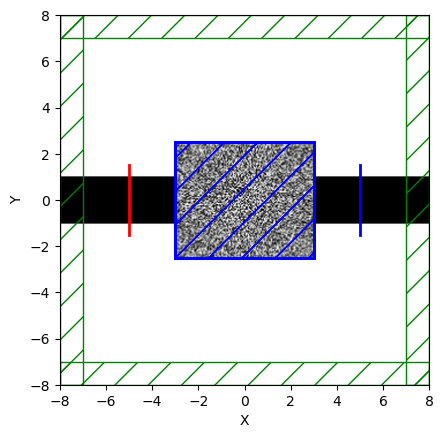

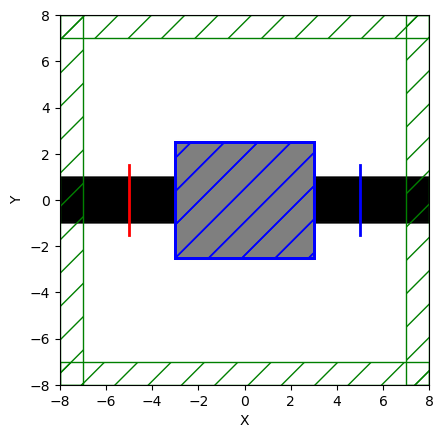

In [16]:
## mode converter ##
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
import matplotlib.pyplot as plt

mp.verbosity(0)

Si = mp.Medium(epsilon=3.4)

resolution = 20

Sx = 16
Sy = 16
cell_size = mp.Vector3(Sx, Sy, 0)
pml_layers = [mp.PML(1.0)]


# source
fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [-5, 0, 0]
source_size = mp.Vector3(0, 3, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency = fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        eig_match_freq=True,
        direction=mp.X,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
        amplitude=1.0
    )
]


# design region
Dx = 6
Dy = 5
design_region_reolution = int(resolution)

Nx = int(Dx * design_region_reolution + 1)
Ny = int(Dy * design_region_reolution + 1)

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny),
                                   mp.air,
                                   Si,
                                   grid_type="U_MEAN")
design_region = mpa.DesignRegion(design_variables,
                                 volume=mp.Volume(center=mp.Vector3(),
                                                  size=mp.Vector3(Dx, Dy)))


# geometry 
geometry = [
    mp.Block(
            center=mp.Vector3(-5.5, 0),
            material=Si,
            size=mp.Vector3(5, 2, 0)
            ),
    mp.Block(
            center=mp.Vector3(5.5, 0),
            material=Si,
            size=mp.Vector3(5, 2, 0)
            ),
    mp.Block(
            center=design_region.center,
            material=design_variables,
            size=design_region.size
            )
]


# simulation
sim =mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution
)

TE_top =mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(center=mp.Vector3(5, 0, 0), size=mp.Vector3(y=3)),
    mode=1
)
ob_list = [TE_top]

def J(alpha):
    return npa.abs(alpha) ** 2


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

x0 = np.random.rand(Nx * Ny)
opt.update_design([x0])

opt.plot2D(True, frequency=fcen)
plt.show()

x0 = 0.5 * np.ones((Nx * Ny, ))
opt.update_design([x0])

opt.plot2D(True)
plt.show()

